<h1 style="font-family:verdana; color:yellow;">Demand Forecasting and Inventory Optimisation</h1>

Table of containts:
* [Importing Libraries](#libraries)
* [Visualisations](#visualise)
* [Data Prerparation](#data-prep)
* [Forecasting](#forecast)
* [Inventory Optimization](#inv-op)

<h2>Importing Libraries<h2><a class="anchor" id="libraries"></a>

In [15]:
# iporting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [16]:
df = pd.read_csv("./Resources/demand_inventory.csv", index_col="Unnamed: 0")
df.head()

,Date,Product_ID,Demand,Inventory
0,2023-06-01,P1,51,5500
1,2023-06-02,P1,141,5449
2,2023-06-03,P1,172,5308
3,2023-06-04,P1,91,5136
4,2023-06-05,P1,198,5045


In [17]:
df.isnull().sum()

Date          0
Product_ID    0
Demand        0
Inventory     0
dtype: int64

In [18]:
df.duplicated().sum()

0

<h2>Visualisations</h2><a class="anchor" id="visualise"></a>

In [19]:
fig_demand = px.line(df,x="Date",y="Demand",title="Demand Over Time")
fig_demand.show()

In [20]:
fig_inventory = px.line(df, x="Date",y="Inventory",title="Inventory Over Time")
fig_inventory.show()

<h2>Data Preparation</h2><a class="anchor" id="data-prep"></a>

In [21]:
df['Date'] = pd.to_datetime(df['Date'], format="ISO8601")
time_series = df.set_index('Date')['Demand']

More about **ISO8601**:
1. **YYYY-MM-DD**: This format is widely used and recommended by the **ISO 8601** standard. It represents the year, month, and day in the order of **year-month-day**. For example, **2024-03-16** corresponds to March 16, 2024.

2. **DD/MM/YYYY** or **DD-MM-YYYY**: In this format, the day comes first, followed by the month and then the year. For instance, **16/03/2024** or **16-03-2024** represents the same date.

3. **MM/DD/YYYY** or **MM-DD-YYYY**: Here, the month precedes the day, followed by the year. For example, **03/16/2024** or **03-16-2024** corresponds to March 16, 2024.

Remember that the ISO 8601 format (**YYYY-MM-DD**) is intended to harmonize date representations across different countries and ensure accuracy. It's a good practice to use this format whenever possible! 📅

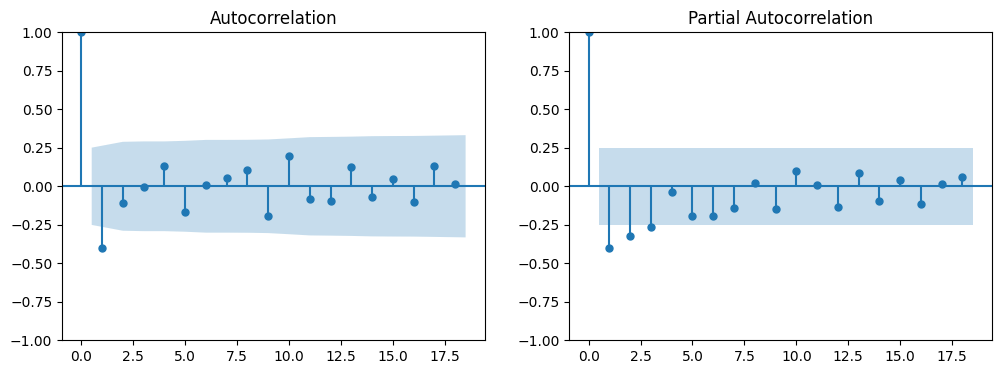

In [22]:
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1,2,figsize=(12,4))
plot_acf(differenced_series,ax=axes[0]) 
plot_pacf(differenced_series,ax=axes[1]) 
plt.show()

<h2>Forecasting</h2><a class="anchor" id="forecast"></a>

In [23]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2) #2 because the data contains a time period of 2 months only
model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)


2023-08-02    117
2023-08-03    116
2023-08-04    130
2023-08-05    114
2023-08-06    128
2023-08-07    115
2023-08-08    129
2023-08-09    115
2023-08-10    129
2023-08-11    115
Freq: D, Name: predicted_mean, dtype: int32


c:\Users\khola\miniconda3\envs\data-analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\khola\miniconda3\envs\data-analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<Axes: xlabel='Date'>

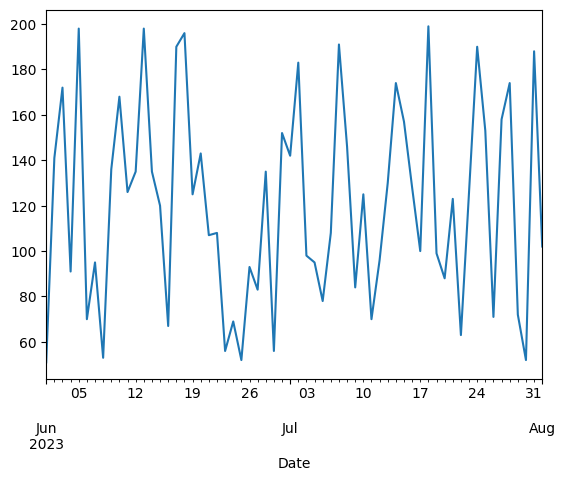

In [24]:
time_series.plot()

<Axes: >

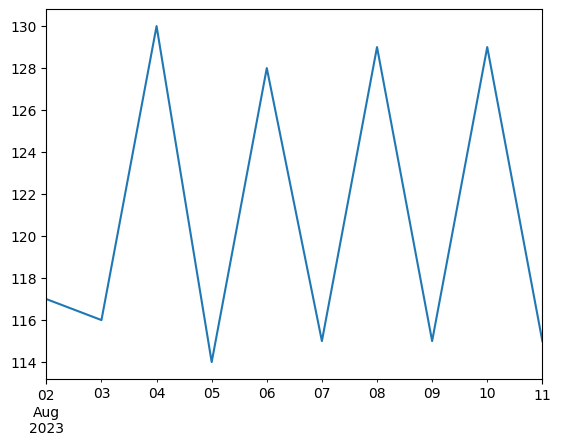

In [25]:
predictions.plot()

<h2>Inventory Optimization</h2><a class="anchor" id="inv-op"></a>

In [26]:
# Create date indices for the future predictions
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')

# Create a pandas Series with the predicted values and date indices
forecasted_demand = pd.Series(predictions, index=future_dates)

# Initial inventory level
initial_inventory = 5500

# Lead time (number of days it takes to replenish inventory) 
lead_time = 1 # it's different for every business, 1 is an example

# Service level (probability of not stocking out)
service_level = 0.95 # it's different for every business, 0.95 is an example

# Calculate the optimal order quantity using the Newsvendor formula
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)

# Calculate the reorder point
reorder_point = forecasted_demand.mean() * lead_time + z

# Calculate the optimal safety stock
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

# Calculate the total cost (holding cost + stockout cost)
holding_cost = 0.1  # it's different for every business, 0.1 is an example
stockout_cost = 10  # # it's different for every business, 10 is an example
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)

# Calculate the total cost
total_cost = total_holding_cost + total_stockout_cost

print("Optimal Order Quantity:", order_quantity)
print("Reorder Point:", reorder_point)
print("Safety Stock:", safety_stock)
print("Total Cost:", total_cost)

Optimal Order Quantity: 236
Reorder Point: 235.25
Safety Stock: 114.45
Total Cost: 561.8000000000001
